# Minimizing the radius of an extremal EoS -- varying $\epsilon_{\Delta}$ and $c_{s,\,\mathrm{upper}}$

In [1]:
# For measuring runtime
import time
start_time = time.time()

In [2]:
import numpy as np
from scipy.integrate import solve_ivp, odeint, quad
from astropy.constants import G, c
from numpy import pi
import astropy.units as u
import matplotlib.pyplot as plt
import sys
import math
np.set_printoptions(threshold=sys.maxsize)
from scipy import optimize
from sympy import symbols, diff
import csv

In [3]:
# Using natural units
# 197 MeV * fm = 1
# 1 fm = 1 / (197 MeV)
# 3e8 m = 1 s
# 3e8 m / s = 1
# 1 J = 1 kg * (m / s)^2
# 1 J = 1 / 9e16 kg

natural = [(u.MeV, u.fm ** (-1), lambda fm_inverse: 1 / 197 * fm_inverse, lambda MeV: 197 * MeV),
           (u.m, u.s, lambda s: 1 / c.value * s, lambda m: c.value * m),
           (u.kg, u.J, lambda J: c.value ** 2 * J, lambda kg: 1 / c.value ** 2 * kg),
           (u.m / u.s, u.dimensionless_unscaled, lambda dimensionless: 1 / c.value * dimensionless, lambda v: c.value * v),
           (u.fm, u.MeV ** (-1), lambda MeV_inverse: 1 / 197 * MeV_inverse, lambda fm: 197 * fm)
          ]

G = (G.value * (1 * u.m / u.s).to(u.dimensionless_unscaled, equivalencies = natural) ** 2 * (1 * u.m).to(u.fm).to(1 / u.MeV, equivalencies = natural) / (1 * u.kg).to(u.J, equivalencies = natural).to(u.MeV))
G = G.value

## Functions to find numerical EoS arrays for piecewise EoS given some number density (in natural units)

In [4]:
# Non-rest-mass energy E
def find_E(num_density):
    result = a * (num_density / n_0) ** alpha + b * (num_density / n_0) ** beta
    return result

# Energy density epsilon
def find_epsilon(num_density):
    E = find_E(num_density)
    result = num_density * (E + m_N)
    return result

# Chemical potential
def find_chem_potential(num_density):
    result = a * (alpha + 1) * (num_density / n_0) ** alpha + b * (beta + 1) * (num_density / n_0) ** beta + m_N
    return result

# Pressure
# Pass in epsilon_D in MeV / fm^3
def find_pressure(num_density, epsilon_D, c_s_Upper):
    epsilon = find_epsilon(num_density)
    chem_potential = find_chem_potential(num_density)

    epsilon_Delta = epsilon_D * u.MeV / (1 * u.fm).to(1 / u.MeV, equivalencies = natural) ** 3
    
    num_density_c = num_density_from_energy_density(epsilon_c.value) * u.MeV ** 3
    chem_potential_c = find_chem_potential(num_density_c)
    pressure_c = - epsilon_c + chem_potential_c * num_density_c
    
    # Piece-wise extremal EoS
    if epsilon.value < epsilon_c.value:
        result = - epsilon + chem_potential * num_density    # Gandolfi nuclear EoS
    else:
        if epsilon.value < epsilon_Delta.value:
            result = pressure_c    # Flat EoS
        else:
            result = pressure_c + c_s_Upper * (epsilon - epsilon_Delta)    # EoS slope = c_s_Upper
    
    return result

In [5]:
# Finding number density as a function of energy density

def energy_density_minus_target_epsilon(n, target_epsilon):
    n = n * u.MeV ** 3
    result = find_epsilon(n).value - target_epsilon
    return result

# Takes input parameter epsilon in MeV^4
def num_density_from_energy_density(epsilon):
    b = 10 ** 12
    if energy_density_minus_target_epsilon(0, epsilon) > 0:
        print(f"find_epsilon is {find_epsilon(0 * u.MeV ** 3)} and epsilon is {epsilon}.")
        return
    result = optimize.brentq(energy_density_minus_target_epsilon,
                             0,
                             b,
                             args = (epsilon,))
    return result

## Plotting the EoS

In [6]:
# epsilon = []
# pressure = []

# n = np.logspace(-0.3, 1, num = 200) * n_0

# for num_density in n:
#     epsilon_in_MeV = find_epsilon(num_density).value
#     epsilon_in_MeV_and_fm = epsilon_in_MeV * (1 * u.MeV).to(1 / u.fm, equivalencies = natural) ** 3
#     epsilon.append(epsilon_in_MeV_and_fm.value)
#     pressure_in_MeV = find_pressure(num_density, epsilon_D).value
#     pressure_in_MeV_and_fm = pressure_in_MeV * (1 * u.MeV).to(1 / u.fm, equivalencies = natural) ** 3
#     pressure.append(pressure_in_MeV_and_fm.value)

In [7]:
# fig, ax = plt.subplots(figsize = (8, 8))

# epsilon_c_MeV_and_fm = epsilon_c * (1 * u.MeV).to(1 / u.fm, equivalencies = natural) ** 3
# epsilon_delta_MeV_and_fm = epsilon_delta * (1 * u.MeV).to(1 / u.fm, equivalencies = natural) ** 3
# ax.set_title("Equation of state", fontsize = 15);
# ax.set_xlabel(r"$\mathrm{Energy\,density}\,\epsilon\,\left(\mathrm{MeV/\,fm^3}\right)$", fontsize = 15);
# ax.set_ylabel(r"$\mathrm{Pressure\,\left(MeV/\,fm^3\right)}$", fontsize = 15);
# ax.set_xlim(0, epsilon_delta_MeV_and_fm.value + 25);
# ax.set_ylim(0, 25);
# ax.plot(epsilon, pressure, label = "EoS");
# ax.axvline(x = epsilon_c_MeV_and_fm.value, color = "red", linewidth = 0.5, label = r"$\epsilon_{c}=150\,\mathrm{MeV/\,fm^3}$");
# ax.axvline(x = epsilon_delta_MeV_and_fm.value, color = "green", linewidth = 0.5, label = r"$\epsilon_{\Delta}=650\,\mathrm{MeV/\,fm^3}$");
# ax.legend(fontsize = 15);

# plt.savefig("Piecewise_EoS.pdf", bbox_inches = "tight");
# plt.savefig("Piecewise_EoS.jpg", bbox_inches = "tight");

## Generalized TOV

In [8]:
# r = distance from center
# m = cumulative mass enclosed within distance r from center
# p = pressure at distance r from center
# epsilon = energy density at distance r from center

# TOV coded to be compatible w/ cgs units, but can't explicitly give units in code b/c solve_ivp() throws errors

def TOV(r, p_and_m, n_central, epsilon_D, c_s_Upper):
    p = p_and_m[0]
    m = p_and_m[1]
    
    if num_density_from_pressure(p, r, n_central, epsilon_D, c_s_Upper) is None:
        return [0, 0]
        
    n = num_density_from_pressure(p, r, n_central, epsilon_D, c_s_Upper) * u.MeV ** 3
    epsilon = find_epsilon(n).value
    print(f"number density is {n}")
    rel_factors = (1 + p / epsilon) * (1 + 4 * pi * r ** 3 * p / m) * (1 - 2 * G * m / r) ** (-1)
    p_result = - G * epsilon * m / r ** 2 * rel_factors
    m_result = 4 * pi * r ** 2 * epsilon
    return [p_result, m_result]

In [9]:
# Finding number density as a function of pressure

def pressure_minus_target_p(n, target_p, epsilon_D, c_s_Upper):
    n = n * u.MeV ** 3
    result = find_pressure(n, epsilon_D, c_s_Upper).value - target_p
    return result

def find_pressure_brentq_b(n_central):
    slope = (0.125 * 10 ** 8) / n_0.value
    intercept = 10 ** 8 - slope * 8 * n_0.value
    result = slope * n_central + intercept
    return result

def num_density_from_pressure(p, r, n_central, epsilon_D, c_s_Upper):
    if pressure_minus_target_p(0, p, epsilon_D, c_s_Upper) > 0:
        print(f"Distance from center is {(r / u.MeV).to(u.fm, equivalencies = natural).to(u.km)}, w/ find_pressure {find_pressure(0 * u.MeV ** 3, epsilon_D, c_s_Upper)} and p {p}.")
        return

    pressure_brentq_b = find_pressure_brentq_b(n_central)
    
    result = optimize.brentq(pressure_minus_target_p,
                             0,
                             pressure_brentq_b,
                             args = (p, epsilon_D, c_s_Upper)
                            )
    
    return result

### Setting central cumulative mass initial condition

In [10]:
def M_from_r_and_rho(r, rho):
    result = 4 * pi * rho * r ** 3 / 3
    return result

### TOV solver function

In [11]:
# Keep this for all EoS

def solve_TOV(n_central, p_central, epsilon_D, c_s_Upper):
    epsilon_central = find_epsilon(n_central * u.MeV ** 3).value
    m_central = M_from_r_and_rho(small_r, epsilon_central)
    
    def reached_surface(t, y, *args):
        return y[0]

    reached_surface.terminal = True
    reached_surface.direction = -1
    
    solution = solve_ivp(TOV,
                         [small_r, R_attempt],
                         [p_central, m_central],
                         events = reached_surface,
                         args = (n_central, epsilon_D, c_s_Upper)
                        )

    distance_from_center = (solution.t / u.MeV).to(u.fm, equivalencies = natural).to(u.km)
    print(f"Mass is {(solution.y[1][-1] * u. MeV).to(u.J).to(u.kg, equivalencies = natural).to(u.solMass):.3f}.")
    cumulative_mass = (solution.y[1] * u.MeV).to(u.J).to(u.kg, equivalencies = natural).to(u.solMass)
    pressure = solution.y[0]

    result = distance_from_center, cumulative_mass, pressure
    return result

### Setting constants for solving TOV

In [12]:
# Everything in natural units unless otherwise specified
# r_small cannot be 0 b/c it would cause a singularity.

small_r = (0.1 * u.km).to(u.fm).to(1 / u.MeV, equivalencies = natural).value
m_N = 939.565 * u.MeV    # Natural units
n_0 = 0.16 / (1 * u.fm).to(1 / u.MeV, equivalencies = natural) ** 3    # Nuclear saturation density

# Setting nuclear parameters (from Gandolfi et. al.)
a = 13.0 * u.MeV
alpha = 0.49
b = 3.21 * u.MeV
beta = 2.47

# Setting critical energy density corresponding to n_0 for piece-wise EoS
epsilon_c_value = 150    # In MeV / fm^3
epsilon_c = epsilon_c_value * u.MeV / (1 * u.fm).to(1 / u.MeV, equivalencies = natural) ** 3
# Note: need to specify epsilon_delta before solving TOV for piece-wise EoS

### Horizontal axis scale

In [13]:
# Everything in natural units unless otherwise specified

R_attempt = (100 * u.km).to(u.fm).to(1 / u.MeV, equivalencies = natural).value

### Solving TOV example

In [14]:
# # Nuclear saturation number density is 0.16 fm^(-3)
# n_central = 7 * n_0
# print(f"{n_0:.3e}")
# p_central = find_pressure(n_central, epsilon_D).value
# print(f"p_central is {p_central}")
# distance_from_center, cumulative_mass, pressure = solve_TOV(n_central.value, p_central)

In [15]:
# fig, [ax1, ax2] = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 8))

# ax1.set_title("Cumulative mass vs distance from center", fontsize = 18);
# ax1.set_xlabel("Distance from center (km)", fontsize = 18);
# ax1.set_ylabel(r"Cumulative mass ($\mathrm{M_{\odot}}$)", fontsize = 18);
# # ax1.set_xlim(0, 20);
# # ax1.set_ylim(0, 0.6);
# ax1.plot(distance_from_center, cumulative_mass);
# ax2.set_title("Pressure vs distance from center", fontsize = 18);
# ax2.set_xlabel("Distance from center (km)", fontsize = 18);
# ax2.set_ylabel(r"Pressure $\left(\mathrm{MeV/\,fm^3}\right)$", fontsize = 18);
# # ax2.set_xlim(0, 20);
# ax2.plot(distance_from_center, pressure);

In [16]:
# print(f"Mass is {np.max(cumulative_mass):.2f}.")

## Finding the minimum radius for a given EoS

In [17]:
# Function to find mass and radius for particular central number density and EoS parameters
def find_mass_radius(num_density, epsilon_D, c_s_Upper):
    # Solving TOV
    p_central = find_pressure(num_density, epsilon_D, c_s_Upper).value
    distance_from_center, cumulative_mass, _ = solve_TOV(num_density.value, p_central, epsilon_D, c_s_Upper)
    print(f"Solved TOV for epsilon_delta {epsilon_D} MeV / fm^3 and c_s_upper {c_s_Upper}")

    # Calculating runtime
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Elapsed time: {elapsed_time} seconds")

    # Removing NaN and inf values
    cumulative_mass = cumulative_mass[~np.isnan(cumulative_mass)]
    cumulative_mass = cumulative_mass[~np.isinf(cumulative_mass)]

    # Picking out single values
    mass = cumulative_mass[-1].value
    radius = distance_from_center[-1].value
    
    return mass, radius

In [18]:
# Function to fit a parabola to 3 data points of mass or radius that vary w/ number density and identify the extremum
def find_extremum(n_attempts, y_array, y2, extremum_index, epsilon_D, c_s_upper, display_max_parab = False):
    # Finding 3 calculated points in oscillation
    x2 = n_attempts[extremum_index]
    x1 = n_attempts[extremum_index - 1]
    y1 = y_array[extremum_index - 1]
    x3 = n_attempts[extremum_index + 1]
    y3 = y_array[extremum_index + 1]
    print(f"x1 = {x1}")
    print(f"x2 = {x2}")
    print(f"x3 = {x3}")
    print(f"y1 = {y1}")
    print(f"y2 = {y2}")
    print(f"y3 = {y3}")
    
    # Fitting parabola parameters
    b_parab = ((y3 - y2) * (x2 ** 2 - x1 ** 2) / (x2 ** 2 - x3 ** 2) + y2 - y1) / ((x1 ** 2 - x2 ** 2) / (x2 + x3) + x2 - x1)
    a_parab = (b_parab * x3 - y3 - b_parab * x2 + y2) / (x2 ** 2 - x3 ** 2)
    c_parab = y1 - a_parab * x1 ** 2 - b_parab * x1
    print(f"a_parab = {a_parab}")
    print(f"b_parab = {b_parab}")
    print(f"c_parab = {c_parab}")
    
    # Calculating extremum from parabola
    x_extremum = - b_parab / 2 / a_parab
    print(f"x_extremum = {x_extremum}")

    # Displaying max_parab
    if display_max_parab:
        max_parab = a_parab * x_extremum ** 2 + b_parab * x_extremum + c_parab
        print(f"max_parab = {max_parab}")
    
    # Solving TOV for extremum
    n_extremum = x_extremum * u.MeV ** 3    # Adding units for TOV solver
    mass_extremum, radius_extremum = find_mass_radius(n_extremum, epsilon_D, c_s_upper)
    
    return mass_extremum, radius_extremum, n_extremum

In [19]:
# Identifying the lowest central number density to search
n_low = num_density_from_energy_density(0.1 * epsilon_c.value)    # 1 order of magnitude lower than first phase transition
n_exp_low = np.log10(n_low)

In [20]:
# Function to find the minimum radius for a given EoS -- 2 parameters, epsilon_delta and c_s_Upper
def find_min_radius(epsilon_D, c_s_Upper):
    # Creating empty masses, radius_candidates, n_attempts arrays to be populated
    masses = []
    radius_candidates = []
    n_attempts = []

    # Creating initial array of central number densities
    # n_high is 1 order of magnitude higher than second phase transition to ensure that global maximum mass is not missed
    n_high = num_density_from_energy_density(10 * (epsilon_D * u.MeV / (1 * u.fm).to(1 / u.MeV, equivalencies = natural) ** 3).value)
    n_exp_high = np.log10(n_high)
    n_central = np.logspace(n_exp_low, n_exp_high, num = 50) * u.MeV ** 3
    print(f"n_exp_low = {n_exp_low}")
    
    for n_attempt in n_central:
        # Solving TOV
        mass, radius_candidate = find_mass_radius(n_attempt, epsilon_D, c_s_Upper)
        masses.append(mass)
        radius_candidates.append(radius_candidate)
        n_attempts.append(n_attempt.value)

    # Verifying that maximum mass is reached
    n_exp_step = (n_exp_high - n_exp_low) / (50 - 1)
    
    while np.max(masses) == masses[-1] or np.max(masses) == masses[-2] or masses[-1] > masses[-2] or masses[-2] > masses[-3]:
        n_exp_high += n_exp_step
        n_attempt = 10 ** n_exp_high * u.MeV ** 3
        mass, radius_candidate = find_mass_radius(n_attempt, epsilon_D, c_s_Upper)
        masses.append(mass)
        radius_candidates.append(radius_candidate)
        n_attempts.append(n_attempt.value)

    # Identifying maximum mass using parabola fit
    y2 = np.max(masses)
    max_index = np.argmax(masses)
    max_mass_parabola, radius_candidate, n_max = find_extremum(n_attempts, masses, y2, max_index, epsilon_D, c_s_Upper, display_max_parab = True)
    masses.append(max_mass_parabola)
    radius_candidates.append(radius_candidate)
    n_attempts.append(n_max.value)

    # Identifying true maximum mass and corresponding density
    max_mass = np.max(masses)
    max_mass_index = np.argmax(masses)
    n_attempt_crit = n_attempts[max_mass_index]
    
    # Throwing out any EoS that yields non-realistic neutron star masses
    if max_mass < 1:
        print("Maximum mass is less than 1 solar mass -- not a realistic neutron star")
        min_radius = None
        
        # Finding extra data
        mass_of_min_radius = None
        n_central_of_min_radius = None
        radius_of_max_mass = radius_candidates[max_mass_index]
        n_central_of_max_mass = n_attempt_crit
    
        # Packing extra data
        extra_data = [mass_of_min_radius, n_central_of_min_radius, max_mass, radius_of_max_mass, n_central_of_max_mass]
    
        return min_radius, extra_data
    
    # Finding indices to remove
    bad_indices = []
    
    for i in range(np.size(n_attempts)):
        n_attempt_value = n_attempts[i]
        
        if n_attempt_value > n_attempt_crit:
            bad_indices.append(i)
    
    # Removing any values at densities greater than maximum density
    radius_candidates = np.delete(radius_candidates, bad_indices)
    masses = np.delete(masses, bad_indices)
    n_attempts = np.delete(n_attempts, bad_indices)

    # Creating placeholder value of min_radius_result
    min_radius_result = 100    # Must be an overestimate

    # Identifying smallest radius value that has a realistic neutron star mass
    for i in range(np.size(masses)):
        radius_candidate_value = radius_candidates[i]
        mass_value = masses[i]
            
        if radius_candidate_value < min_radius_result and mass_value > 1:
            min_radius_result = radius_candidate_value

    # Default value of true_min_radius is min_radius_result
    true_min_radius = min_radius_result
    
    # Checking if minimum radius does not correspond to maximum mass
    min_index = np.where(radius_candidates == min_radius_result)[0][0]
    max_mass_index = np.argmax(masses)    # Refreshing this value after deleting bad indices

    if min_index != max_mass_index and min_index != np.size(radius_candidates) - 1:
        # Identifying true minimum radius using parabola fit
        y2 = min_radius_result
        mass_of_min_radius_parabola, min_radius_parabola, n_central_of_min_radius_parabola = find_extremum(n_attempts, radius_candidates, y2, min_index, epsilon_D, c_s_Upper)
        masses = np.append(masses, mass_of_min_radius_parabola)
        radius_candidates = np.append(radius_candidates, min_radius_parabola)
        n_attempts = np.append(n_attempts, n_central_of_min_radius_parabola.value)
        
        # Identifying true minimum radius
        if min_radius_parabola < min_radius_result and mass_of_min_radius_parabola > 1:
            true_min_radius = min_radius_parabola
    
    # Recording minimum radius
    print(f"The minimum radius is {true_min_radius:.3f} km, while epsilon_delta is {epsilon_D:.3f} MeV / fm^3, and c_s_upper is {c_s_Upper:.3f}.")

    # Finding extra data
    min_radius_index = np.where(radius_candidates == true_min_radius)[0][0]
    mass_of_min_radius = masses[min_radius_index]
    n_central_of_min_radius = n_attempts[min_radius_index]
    radius_of_max_mass = radius_candidates[max_mass_index]
    n_central_of_max_mass = n_attempt_crit
    
    # Packing extra data
    extra_data = [mass_of_min_radius, n_central_of_min_radius, max_mass, radius_of_max_mass, n_central_of_max_mass]
    
    return true_min_radius, extra_data

## Surveying minimum radius while varying $\epsilon_{\Delta}$ and $c_{s,\,\mathrm{upper}}$

In [21]:
# Setting piece-wise EoS parameters to check
N = 10

epsilon_low = epsilon_c_value    # This would mean no flat segment
epsilon_high = epsilon_low * 10
epsilon_delta = np.linspace(epsilon_low, epsilon_high, N)

c_s_upper_low = 0.01
c_s_upper_high = 1
c_s_upper = np.linspace(c_s_upper_low, c_s_upper_high, N)

In [22]:
# Creating placeholder values for epsilon_delta_constraint and c_s_upper_constraint
epsilon_delta_constraint = epsilon_delta[0]
c_s_upper_constraint = c_s_upper[0]

# Creating placeholder value of min_radius
min_radius = 100

# Creating empty radii array to be populated during iterations
c_s_upper_size = np.size(c_s_upper)
epsilon_delta_size = np.size(epsilon_delta)
# radii = np.zeros((c_s_upper_size, epsilon_delta_size))

radii = [[None, 11.271650844007338, 13.157858828273495, 13.25497633229328, 14.09565163454094, 13.549309499045082, 14.0747336511729, 14.567595184678478, 14.988682072378538, 15.362923921733092],
         [None, None, 9.31561330266046, 10.175619862345588, 10.783077383166592, 10.821507744578458, 11.126448626897224, 11.408977441409338, 10.821230634045177, 11.082810081954868],
         [None, None, 7.660544754877495, 8.140352982890537, 8.357588168007037, 8.847910506908718, 9.222138395077215, 9.131343165335588, 8.602988745846478, 9.538566848507891],
         [None, None, None, 7.191638068073909, 7.624480080981313, 7.932941669601865, 8.18487285778002, 8.165589742838284, 8.39354985184011, 8.536356056926522],
         [None, None, None, 6.408867342726115, 6.797491145663929, 7.130186961639795, 7.300649183717964, 7.529214400667992, 7.543709133839845, 7.685266688610487],
         [None, None, None, 5.826585975268626, 6.198656844828345, 6.48053520133304, 6.692288756619933, 6.871723493362504, 6.981709324120399, 7.135107124329368],
         [None, None, None, None, 5.742868104894698, 6.01458094419113, 6.181120352009212, 6.353472720525058, 6.481395447282641, 6.60043631582746],
         [None, None, None, None, 5.387858755441549, 5.611541451787504, 5.793004428461907, 5.976816927145717, 6.055175822049074, 6.171708686828228],
         [None, None, None, None, None, 5.277764960690043, 5.464856394039518, 5.587593477688177, 5.7134663650284745, 5.815916816577294],
         [None, None, None, None, None, 5.008871314224017, 5.180346885654346, 5.303134277331731, 5.458569692352253, 5.524239410632531]
        ]

# Opening csv file
with open("radius_minimization_2D_mass_agnostic.csv", "w") as outfile:
    data_writer = csv.writer(outfile)

    # Header row
    data_writer.writerow(["epsilon_delta (MeV / fm^3)",
                          "c_s_upper",
                          "Minimum radius (km)",
                          "Elapsed time (s)",
                          "Mass of min radius (solMass)",
                          "n_central of min radius (MeV^3)",
                          "Maximum mass (solMass)",
                          "Radius of max mass (km)",
                          "n_central of max mass (MeV^3)"
                         ])

    # Iterating through EoS parameter arrays to find minimum radii
    for i in range(epsilon_delta_size):
        epsilon_delta_value = epsilon_delta[i]
        
        for j in range(c_s_upper_size):
            c_s_upper_value = c_s_upper[j]
            
            if radii[i][j] == 0:    # If not yet searched
                radius_value, extra_data = find_min_radius(epsilon_delta_value, c_s_upper_value)
            else:    # If already searched
                radius_value = radii[i][j]
                extra_data = ["See previous csv files for extra data", None, None, None, None]

            # Calculating runtime
            end_time = time.time()
            elapsed_time = end_time - start_time

            # Unpacking extra data
            mass_of_min_radius = extra_data[0]
            n_central_of_min_radius = extra_data[1]
            max_mass = extra_data[2]
            radius_of_max_mass = extra_data[3]
            n_central_of_max_mass = extra_data[4]
            
            data_writer.writerow([epsilon_delta_value,
                                  c_s_upper_value,
                                  radius_value,
                                  elapsed_time,
                                  mass_of_min_radius,
                                  n_central_of_min_radius,
                                  max_mass,
                                  radius_of_max_mass,
                                  n_central_of_max_mass
                                 ])
            
            radii[i][j] = radius_value

            # Identifying smallest value
            if radius_value is not None and radius_value < min_radius:
                min_radius = radius_value
                epsilon_delta_constraint = epsilon_delta_value
                c_s_upper_constraint = c_s_upper_value

In [23]:
# Converting None values to np.nan so that contour plot can read it
radii = np.array(radii, dtype = np.float64)

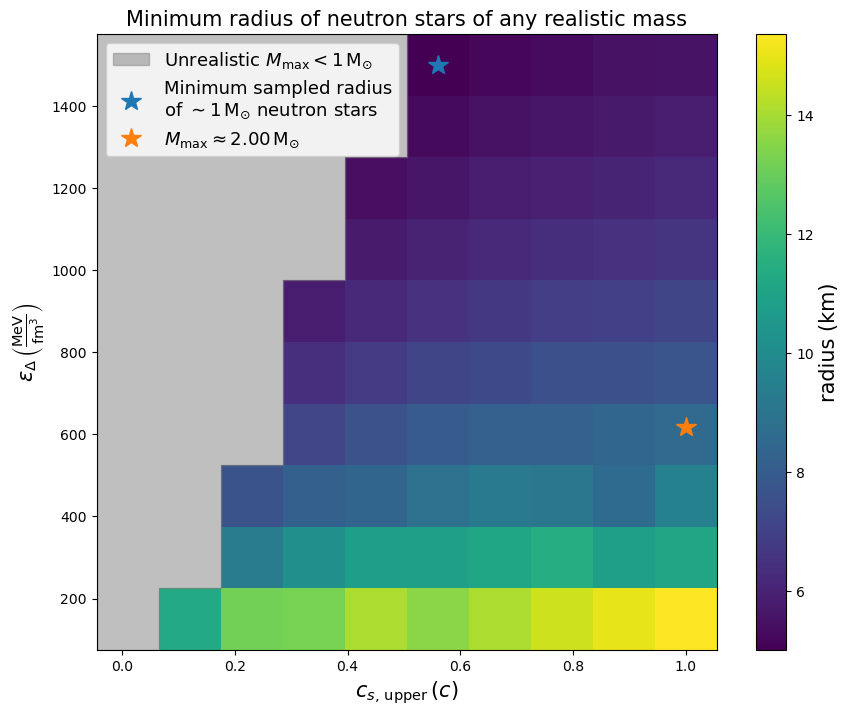

In [24]:
# Plotting minimum radius vs EoS parameters

fig, ax = plt.subplots(figsize = (10, 8));

ax.set_title("Minimum radius of neutron stars of any realistic mass",
             fontsize = 15
            );

ax.set_xlabel(r"$c_{s,\,\mathrm{upper}}\,\left(c\right)$", fontsize = 15);

ax.set_ylabel(r"$\epsilon_{\Delta}\,\left(\frac{\mathrm{MeV}}{\mathrm{fm}^3}\right)$",
              fontsize = 15
             );

ax.set_xlim(-0.045, 1.055);
ax.set_ylim(75, 1575);
# radius_contour = ax.contour(c_s_upper, epsilon_delta, radii);
# ax.clabel(radius_contour);
plt.pcolormesh(c_s_upper, epsilon_delta, radii);
cbar = plt.colorbar();
cbar.set_label("radius (km)", fontsize = 15);

# Noting unrealistic mass region
ax.fill([-0.045, 0.065, 0.065, 0.175, 0.175, 0.285, 0.285, 0.395, 0.395, 0.505, 0.505, -0.045],
        [75, 75, 225, 225, 525, 525, 975, 975, 1275, 1275, 1575, 1575],
        color = "grey",
        alpha = 0.5,
        label = "Unrealistic $M_{\mathrm{max}}<1\,\mathrm{M}_{\odot}$"
       );

ax.plot(c_s_upper_constraint,
        epsilon_delta_constraint,
        marker = "*",
        linestyle = "",
        markersize = 15,
        label = "Minimum sampled radius\n"r"of $\sim1\,\mathrm{M}_{\odot}$ neutron stars"
       );

# Noting 2.00 solar mass maximum, for reference
ax.plot(1.0,
        618.367,
        marker = "*",
        linestyle = "",
        markersize = 15,
        label = r"$M_{\mathrm{max}}\approx2.00\,\mathrm{M}_{\odot}$"
       );

ax.legend(fontsize = 13);

# Saving plot if result is notable
plt.savefig("min_radius_vs_epsilon_delta_and_c_s_upper.jpg", bbox_inches = "tight");
plt.savefig("min_radius_vs_epsilon_delta_and_c_s_upper.pdf", bbox_inches = "tight");

In [25]:
# Adding units
epsilon_delta = epsilon_delta * u.MeV / (1 * u.fm) ** 3
radii = radii * u.km

min_radius = min_radius * u.km
epsilon_delta_constraint = epsilon_delta_constraint * u.MeV / (1 * u.fm) ** 3

In [26]:
# Displaying minimum radius and corresponding EoS parameters
print(f"The minimum radius is {min_radius:.3f}.")
print(f"The value of epsilon_delta that minimizes the radius is {epsilon_delta_constraint:.3f}.")
print(f"The value of c_s_upper that minimizes the radius is {c_s_upper_constraint:.3f}.")

The minimum radius is 5.009 km.
The value of epsilon_delta that minimizes the radius is 1500.000 MeV / fm3.
The value of c_s_upper that minimizes the radius is 0.560.


In [27]:
# Printing the results
print("radii:")
print(radii)
print("epsilon_delta:")
print(epsilon_delta)
print("c_s_upper:")
print(c_s_upper)

radii:
[[        nan 11.27165084 13.15785883 13.25497633 14.09565163 13.5493095
  14.07473365 14.56759518 14.98868207 15.36292392]
 [        nan         nan  9.3156133  10.17561986 10.78307738 10.82150774
  11.12644863 11.40897744 10.82123063 11.08281008]
 [        nan         nan  7.66054475  8.14035298  8.35758817  8.84791051
   9.2221384   9.13134317  8.60298875  9.53856685]
 [        nan         nan         nan  7.19163807  7.62448008  7.93294167
   8.18487286  8.16558974  8.39354985  8.53635606]
 [        nan         nan         nan  6.40886734  6.79749115  7.13018696
   7.30064918  7.5292144   7.54370913  7.68526669]
 [        nan         nan         nan  5.82658598  6.19865684  6.4805352
   6.69228876  6.87172349  6.98170932  7.13510712]
 [        nan         nan         nan         nan  5.7428681   6.01458094
   6.18112035  6.35347272  6.48139545  6.60043632]
 [        nan         nan         nan         nan  5.38785876  5.61154145
   5.79300443  5.97681693  6.05517582  6.17170

In [28]:
# Calculating runtime
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Elapsed time: 4.647541284561157 seconds
